[Summary]

Below list the general step of modeling:
 
Check the general correlation between sales of the 3 products and different segments.

Sales prediction:
Using classification methods to predict the sale_MF, sale_CC, sale_CL.
In MF part, I tried to build logistic regression and decision tree, and decision tree works better. So I used decision tree for all 3 products' sale prediction.
(Products_ActBalance columns was dropped for this step, since there are too many null values.)

Revenue prediction:
Using linear regression for revenue prediction.
For revenue prediction, some related columns in Products_ActBalance columns was included in the training data when building model. For example, Count_MF and ActBal_MF for MF revenue prediction. I replaced those null value by 0.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

1. Import Train data 
  Training data is joined select from 4 tables, where Targets are not null. And the Sex was replaced by numeric data - M1 F0.

In [2]:
df = pd.read_csv('model/base.csv')

In [3]:
del_cols = [ 'CLIENT', 'Count_SA', 'Count_MF','Count_OVD', 'Count_CC', 'Count_CL','ActBal_SA','ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
for col in del_cols:
    del df[col]

For the rest columns, check the correlation between segments and sales

In [4]:
corr = df.corr()
corr

,Sex,Age,Tenure,Count_CA,ActBal_CA,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Sex,1.000000,0.027182,-0.022083,0.046202,0.067365,0.000908,0.001253,0.052882,0.062119,0.010967,...,0.005749,-0.044802,0.002895,0.046420,0.048783,-0.005364,-0.035595,0.044842,-0.037741,-0.026639
Age,0.027182,1.000000,-0.033163,0.032377,-0.033100,0.001972,-0.010758,0.043815,0.037448,0.010380,...,0.015264,-0.017195,-0.001393,0.055594,-0.029232,0.044249,-0.173893,0.047046,0.026714,-0.128329
Tenure,-0.022083,-0.033163,1.000000,0.026385,0.047593,-0.032893,-0.023290,-0.025332,-0.032828,-0.017675,...,0.025770,-0.014309,0.027312,0.021407,-0.005537,0.015303,0.180419,-0.007528,0.000093,0.169554
Count_CA,0.046202,0.032377,0.026385,1.000000,0.000361,-0.028907,-0.035477,0.004268,0.011364,-0.025107,...,-0.003952,-0.004021,-0.010127,-0.009832,0.001482,-0.031212,0.082731,0.000978,-0.022189,0.058075
ActBal_CA,0.067365,-0.033100,0.047593,0.000361,1.000000,0.041870,0.022568,0.119238,0.122376,0.041733,...,0.075773,0.034166,0.073329,0.019533,-0.043749,0.162384,-0.055871,0.003895,0.009028,-0.024567
VolumeCred,0.000908,0.001972,-0.032893,-0.028907,0.041870,1.000000,0.924795,0.183499,0.148469,0.905529,...,0.241972,0.082537,0.177502,0.302497,-0.003366,0.015239,0.005082,0.026236,0.018452,0.008421
VolumeCred_CA,0.001253,-0.010758,-0.023290,-0.035477,0.022568,0.924795,1.000000,0.174576,0.156533,0.820236,...,0.283401,0.105394,0.226789,0.335153,0.015658,-0.002584,-0.007060,0.042530,0.024065,-0.021951
TransactionsCred,0.052882,0.043815,-0.025332,0.004268,0.119238,0.183499,0.174576,1.000000,0.948487,0.246522,...,0.463599,0.254855,0.320506,0.412020,0.073665,0.033696,0.083170,0.022569,0.027156,0.046733
TransactionsCred_CA,0.062119,0.037448,-0.032828,0.011364,0.122376,0.148469,0.156533,0.948487,1.000000,0.206012,...,0.492575,0.269750,0.297702,0.414069,0.081221,0.007772,0.084753,0.023967,0.017244,0.031194
VolumeDeb,0.010967,0.010380,-0.017675,-0.025107,0.041733,0.905529,0.820236,0.246522,0.206012,1.000000,...,0.302773,0.088213,0.232814,0.358278,-0.036300,0.055976,0.061492,-0.016762,0.029173,0.054608


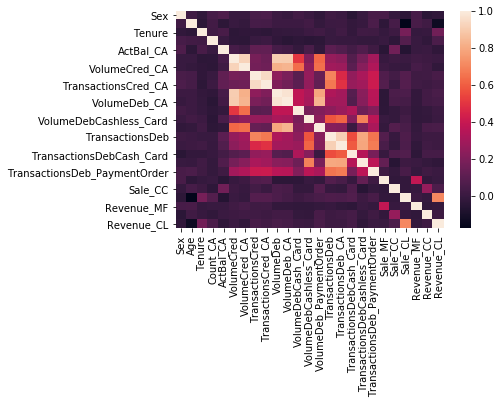

In [5]:
sns.heatmap(corr)

 2. Customer analysis and sales prediction - building model 
 [1] Logistic Regression

In [6]:
x = df.iloc[:,0:-6]
y_mf = df.iloc[:,-6] #Sale_MF
x_train,x_test, mf_train, mf_test = train_test_split(x,y_mf,test_size=0.2, random_state=0)


In [7]:
model_mf = LogisticRegression(penalty='l2', max_iter=1000)
model_mf.fit(x_train, mf_train)

c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
prediction_mf=model_mf.predict(x_test)
from sklearn.metrics import accuracy_score
#Check the accuracy score
accuracy_score(mf_test, prediction_mf)

0.7643979057591623

In [9]:
#Check confusion matrix to evaluate the model
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(mf_test, prediction_mf)
print('MF:',confusion_matrix)
from sklearn.metrics import precision_score
print('MF precision:',precision_score(mf_test, prediction_mf))
from sklearn.metrics import recall_score
print('MF recall:',recall_score(mf_test, prediction_mf))
from sklearn.metrics import f1_score
print('MF F1:',f1_score(mf_test, prediction_mf))


('MF:', array([[141,   1],
       [ 44,   5]], dtype=int64))
('MF precision:', 0.8333333333333334)
('MF recall:', 0.10204081632653061)
('MF F1:', 0.18181818181818182)


In [10]:
from imblearn.over_sampling import SMOTE
samples_mf = SMOTE()
samples_mf_x,samples_mf_y = samples_mf.fit_sample(x_train, mf_train)
print(mf_train.value_counts()/len(mf_train))
print(pd.Series(samples_mf_y).value_counts()/len(samples_mf_y))


0    0.810526
1    0.189474
Name: Sale_MF, dtype: float64
1    0.5
0    0.5
dtype: float64


In [11]:
model_mf2 = LogisticRegression(penalty='l2', class_weight=None, solver='lbfgs', max_iter=1000, multi_class='multinomial')
model_mf2.fit(samples_mf_x,samples_mf_y)

c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
prediction_mf2=model_mf2.predict(x_test)
from sklearn.metrics import accuracy_score
#Check the accuracy score
accuracy_score(mf_test, prediction_mf2)

0.6544502617801047

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(mf_test, prediction_mf2)
print('MF:',confusion_matrix)
from sklearn.metrics import precision_score
print('MF precision:',precision_score(mf_test, prediction_mf2))
from sklearn.metrics import recall_score
print('MF recall:',recall_score(mf_test, prediction_mf2))
from sklearn.metrics import f1_score
print('MF F1:',f1_score(mf_test, prediction_mf2))

('MF:', array([[105,  37],
       [ 29,  20]], dtype=int64))
('MF precision:', 0.3508771929824561)
('MF recall:', 0.40816326530612246)
('MF F1:', 0.3773584905660377)


In [14]:
prediction_mf2=model_mf2.predict(x_test)
accuracy_score(mf_test, prediction_mf2)

0.6544502617801047

Based on the recall and F1, the revised Logistic Regression works better. But the accuracy has decreased.

[2]Decision tree:

In [15]:
dt_mf = tree.DecisionTreeClassifier() 
dt_mf.fit(x_train,mf_train)
pred_mf = dt_mf.predict(x_test)

In [16]:
print(metrics.accuracy_score(mf_test, pred_mf))
print(metrics.classification_report(mf_test, pred_mf))

0.675392670157068
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       142
           1       0.33      0.27      0.30        49

   micro avg       0.68      0.68      0.68       191
   macro avg       0.55      0.54      0.54       191
weighted avg       0.65      0.68      0.66       191



In [17]:
    # check the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(mf_test, pred_mf)
print('MF:',confusion_matrix)

    # evaluation
from sklearn.metrics import precision_score
precision = precision_score(mf_test, pred_mf)
print('MF precision:',precision)

from sklearn.metrics import recall_score
recall = recall_score(mf_test, pred_mf)
print('MF recall:',recall)

from sklearn.metrics import f1_score
print('MF F1:',f1_score(mf_test, pred_mf))


('MF:', array([[116,  26],
       [ 36,  13]], dtype=int64))
('MF precision:', 0.3333333333333333)
('MF recall:', 0.2653061224489796)
('MF F1:', 0.29545454545454547)


In [18]:
dt_mf2 = tree.DecisionTreeClassifier() 
dt_mf2.fit(samples_mf_x,samples_mf_y)
pred_mf2 =dt_mf2.predict(np.array(x_test))

print(metrics.accuracy_score(mf_test, pred_mf2))
print(metrics.classification_report(mf_test, pred_mf2))

0.6649214659685864
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       142
           1       0.36      0.39      0.37        49

   micro avg       0.66      0.66      0.66       191
   macro avg       0.57      0.57      0.57       191
weighted avg       0.67      0.66      0.67       191



In [19]:
    # check the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(mf_test, pred_mf2)
print('MF:',confusion_matrix)

    # evaluation
precision = precision_score(mf_test, pred_mf2)
print('MF precision:',precision)

recall = recall_score(mf_test, pred_mf2)
print('MF recall:',recall)

print('MF F1:',f1_score(mf_test, pred_mf2))


('MF:', array([[108,  34],
       [ 30,  19]], dtype=int64))
('MF precision:', 0.3584905660377358)
('MF recall:', 0.3877551020408163)
('MF F1:', 0.37254901960784315)


The Revised Decision Tree is the better model for MF sales classification.

3. Build Linear Regression for Revenue.

In [20]:
#modify train data - add MF account number and account balance.
df_mf = pd.read_csv('model/base.csv')
df_mf = df_mf.replace(np.nan, 0)
del_cols_mf = ['CLIENT', 'Count_SA', 'Count_OVD', 'Count_CC', 'Count_CL','ActBal_SA', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
for col in del_cols_mf:
    del df_mf[col]

In [21]:
mf_rev_x = df_mf.iloc[:,:-6]
mf_rev_y = df_mf.iloc[:,-3]

x_rev_train,x_rev_val, mf_rev_train, mf_rev_val = train_test_split(mf_rev_x,mf_rev_y,test_size=0.2, random_state=0)

In [22]:
model_mf_rev = LinearRegression()
model_mf_rev.fit(mf_rev_x, mf_rev_y)
mf_rev_pred = model_mf_rev.predict(x_rev_val)
print('MF SVR Score:',model_mf_rev.score(x_rev_val,mf_rev_val))

('MF SVR Score:', 0.013325526033488022)


In [23]:
#predict the revenue of MF based on test data.
df_test = pd.read_csv('model/test.csv')
df_test = df_test.replace(np.nan, 0)
del_cols = [ 'CLIENT', 'Count_SA','Count_OVD', 'Count_CC', 'Count_CL','ActBal_SA','ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
for col in del_cols:
    del df_test[col]

In [24]:
prediction_mf_rev = model_mf_rev.predict(df_test)

In [25]:
# predict the sale of MF based on test data.
df_test_x = pd.read_csv('model/test.csv')
df_test_x = df_test_x .replace(np.nan, 0)
del_cols = [ 'CLIENT', 'Count_SA','Count_MF','Count_OVD', 'Count_CC', 'Count_CL','ActBal_SA','ActBal_MF','ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
for col in del_cols:
    del df_test_x [col]

In [26]:
prediction_mf2=dt_mf2.predict(df_test_x)

In [27]:
mf_rev_x = df_mf.iloc[:,:-6]
mf_rev_y = df_mf.iloc[:,-3]

x_rev_train,x_rev_val, mf_rev_train, mf_rev_val = train_test_split(mf_rev_x,mf_rev_y,test_size=0.2, random_state=0)
model_mf_rev = LinearRegression()
model_mf_rev.fit(mf_rev_x, mf_rev_y)
mf_rev_pred = model_mf_rev.predict(x_rev_val)
print('MF SVR Score:',model_mf_rev.score(x_rev_val,mf_rev_val))

('MF SVR Score:', 0.013325526033488022)


In [28]:
#export the predicted result: Sale and Revenue for MF
np.savetxt('sale_mf.csv',prediction_mf2,delimiter=",")
np.savetxt('rev_mf.csv',prediction_mf_rev,delimiter=",")

4. Below is the similar process for CC and CL.

In [41]:
# Build Decision Tree for CC sale classification.
x = df.iloc[:,:-6]
y_cc = df.iloc[:,-5] #Sale_CC
x_train,x_test, cc_train, cc_test = train_test_split(x,y_cc,test_size=0.2, random_state=0)
dt_cc = tree.DecisionTreeClassifier() 
dt_cc.fit(x_train,cc_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
pred_cc = dt_cc.predict(x_test)
print(metrics.accuracy_score(cc_test, pred_cc))
print(metrics.classification_report(cc_test, pred_cc))

0.6387434554973822
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       143
           1       0.32      0.40      0.36        48

   micro avg       0.64      0.64      0.64       191
   macro avg       0.55      0.56      0.55       191
weighted avg       0.67      0.64      0.65       191



In [43]:
#Check confusion matrix to evaluate the model
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(cc_test, pred_cc)
print('CC:',confusion_matrix)
print('CC precision:',precision_score(cc_test, pred_cc))
print('CC recall:',recall_score(cc_test, pred_cc))
print('CC F1:',f1_score(cc_test, pred_cc))

('CC:', array([[103,  40],
       [ 29,  19]], dtype=int64))
('CC precision:', 0.3220338983050847)
('CC recall:', 0.3958333333333333)
('CC F1:', 0.35514018691588783)


In [44]:
# Use SMOTE to balance the data and revise the model
samples_cc = SMOTE()
samples_cc_x,samples_cc_y = samples_cc.fit_sample(x_train, cc_train)
dt_cc2 = tree.DecisionTreeClassifier() 
dt_cc2.fit(samples_cc_x,samples_cc_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [45]:
pred_cc2 =dt_cc2.predict(np.array(x_test))
print(metrics.accuracy_score(cc_test, pred_cc2))
print(metrics.classification_report(cc_test, pred_cc2))

0.6282722513089005
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       143
           1       0.29      0.33      0.31        48

   micro avg       0.63      0.63      0.63       191
   macro avg       0.53      0.53      0.53       191
weighted avg       0.65      0.63      0.64       191



In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(cc_test, pred_cc2)
print('CC:',confusion_matrix)
from sklearn.metrics import precision_score
print('CC precision:',precision_score(cc_test, pred_cc2))
from sklearn.metrics import recall_score
print('CC recall:',recall_score(cc_test, pred_cc2))
from sklearn.metrics import f1_score
print('CC F1:',f1_score(cc_test, pred_cc2))

('CC:', array([[104,  39],
       [ 32,  16]], dtype=int64))
('CC precision:', 0.2909090909090909)
('CC recall:', 0.3333333333333333)
('CC F1:', 0.31067961165048535)


In [47]:
#Build linear regression for revenue of CC.
#modify train data - add CC account number and account balance.
df_cc = pd.read_csv('model/base.csv')
df_cc = df_cc.replace(np.nan, 0)
del_cols_cc = ['CLIENT', 'Count_SA', 'Count_OVD', 'Count_MF', 'Count_CL','ActBal_SA', 'ActBal_OVD', 'ActBal_MF', 'ActBal_CL']
for col in del_cols_cc:
    del df_cc[col]

In [48]:
#Build Linear Regression for Revenue.

cc_rev_x = df_cc.iloc[:,:-6]
cc_rev_y = df_cc.iloc[:,-2]

x_rev_train,x_rev_val, cc_rev_train, cc_rev_val = train_test_split(cc_rev_x,cc_rev_y,test_size=0.2, random_state=0)


In [49]:
model_cc_rev = LinearRegression()
model_cc_rev.fit(cc_rev_x, cc_rev_y)
mf_rev_pred = model_cc_rev.predict(x_rev_val)
print('CC SVR Score:',model_cc_rev.score(x_rev_val,cc_rev_val))

('CC SVR Score:', -0.02579304016855888)


In [50]:
#predict the revenue of CC based on test data.
df_test = pd.read_csv('model/test.csv')
df_test = df_test.replace(np.nan, 0)
del_cols = [ 'CLIENT', 'Count_SA','Count_OVD', 'Count_CC', 'Count_MF','ActBal_SA','ActBal_OVD', 'ActBal_MF', 'ActBal_CL']
for col in del_cols:
    del df_test[col]
prediction2 = model_cc_rev.predict(df_test)

In [51]:
# Load test data to predict the revenue of CC.
df_test1 = pd.read_csv('model/test.csv')
df_test1 = df_test1.replace(np.nan, 0)
del_cols = [ 'CLIENT', 'Count_SA','Count_OVD', 'Count_MF', 'Count_CL','ActBal_SA','ActBal_OVD', 'ActBal_MF', 'ActBal_CL']
for col in del_cols:
    del df_test1[col]

In [52]:
prediction_cc_rev = model_cc_rev.predict(df_test1)

In [53]:
# Load test data to predict the sales of CC.

df_test_x = pd.read_csv('model/test.csv')
df_test_x = df_test_x.replace(np.nan, 0)
del_cols = [ 'CLIENT', 'Count_SA','Count_MF','Count_OVD', 'Count_CC', 'Count_CL','ActBal_SA','ActBal_MF','ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
for col in del_cols:
    del df_test_x [col]

prediction_cc2=dt_cc.predict(df_test_x)

In [54]:
#export the predicted result: Sale and Revenue for CC
import numpy
np.savetxt('sale_cc.csv',prediction_cc2,delimiter=",")
np.savetxt('rev_cc.csv',prediction_cc_rev,delimiter=",")

In [55]:
# Build Decision Tree for CL sale classification.
x = df.iloc[:,:-6]
y_cl = df.iloc[:,-4] #Sale_CL
x_train,x_test, cl_train, cl_test = train_test_split(x,y_cl,test_size=0.2, random_state=0)
dt_cl = tree.DecisionTreeClassifier() 
dt_cl.fit(x_train,cl_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [56]:
pred_cl = dt_cl.predict(x_test)
print(metrics.accuracy_score(cl_test, pred_cl))
print(metrics.classification_report(cl_test, pred_cl))

0.6649214659685864
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       133
           1       0.44      0.41      0.43        58

   micro avg       0.66      0.66      0.66       191
   macro avg       0.60      0.59      0.60       191
weighted avg       0.66      0.66      0.66       191



In [57]:
#Check confusion matrix to evaluate the model
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(cl_test, pred_cl)
print('CL:',confusion_matrix)
print('CL precision:',precision_score(cl_test, pred_cl))
print('CL recall:',recall_score(cl_test, pred_cl))
print('CL F1:',f1_score(cl_test, pred_cl))

('CL:', array([[103,  30],
       [ 34,  24]], dtype=int64))
('CL precision:', 0.4444444444444444)
('CL recall:', 0.41379310344827586)
('CL F1:', 0.4285714285714286)


In [58]:
samples_cl = SMOTE()
samples_cl_x,samples_cl_y = samples_cl.fit_sample(x_train, cl_train)
dt_cl2 = tree.DecisionTreeClassifier() 
dt_cl2.fit(samples_cl_x,samples_cl_y)
#new decisision tree
pred_cl2 =dt_cl2.predict(np.array(x_test))
print(metrics.accuracy_score(cl_test, pred_cl2))
print(metrics.classification_report(cl_test, pred_cl2))

0.5130890052356021
              precision    recall  f1-score   support

           0       0.66      0.61      0.64       133
           1       0.25      0.29      0.27        58

   micro avg       0.51      0.51      0.51       191
   macro avg       0.46      0.45      0.45       191
weighted avg       0.54      0.51      0.52       191



In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(cl_test, pred_cl2)
print('CL:',confusion_matrix)
print('CL precision:',precision_score(cl_test, pred_cl2))
print('CL recall:',recall_score(cl_test, pred_cl2))
print('CL F1:',f1_score(cl_test, pred_cl2))

('CL:', array([[81, 52],
       [41, 17]], dtype=int64))
('CL precision:', 0.2463768115942029)
('CL recall:', 0.29310344827586204)
('CL F1:', 0.26771653543307083)


Seems like the revised Decision Tree will be used.

In [61]:
#Build linear regression for revenue of CL.
#modify train data - add CL account number and account balance.
df_cl = pd.read_csv('model/base.csv')
df_cl = df_cl.replace(np.nan, 0)
del_cols_cl = ['CLIENT', 'Count_SA', 'Count_OVD', 'Count_MF', 'Count_CC','ActBal_SA', 'ActBal_OVD', 'ActBal_MF', 'ActBal_CC']
for col in del_cols_cl:
    del df_cl[col]

In [62]:
#Build Linear Regression for Revenue.

cl_rev_x = df_cl.iloc[:,:-6]
cl_rev_y = df_cl.iloc[:,-1]

x_rev_train,x_rev_val, cl_rev_train, cl_rev_val = train_test_split(cl_rev_x,cl_rev_y,test_size=0.2, random_state=0)

model_cl_rev = LinearRegression()
model_cl_rev.fit(cc_rev_x, cc_rev_y)
mf_rev_pred = model_cl_rev.predict(x_rev_val)
print('CC SVR Score:',model_cl_rev.score(x_rev_val,cl_rev_val))

prediction_cl_rev = model_cl_rev.predict(df_test)

('CC SVR Score:', -0.34986678758271617)


In [63]:
# Load test data to predict the sales of CL

df_test_x = pd.read_csv('model/test.csv')
df_test_x = df_test_x.replace(np.nan, 0)
del_cols = [ 'CLIENT', 'Count_SA','Count_MF','Count_OVD', 'Count_CC', 'Count_CL','ActBal_SA','ActBal_MF','ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
for col in del_cols:
    del df_test_x [col]

prediction_cl2=dt_cl2.predict(df_test_x)

In [64]:
#export the predicted result: Sale and Revenue for CL
import numpy
np.savetxt('sale_cl.csv',prediction_cl2,delimiter=",")
np.savetxt('rev_cl.csv',prediction_cl_rev,delimiter=",")